# Transfer Learning for Computer Vision

## Table of Contents

1. [Idea of Transfer Learning](#first-bullet)
2. [Popular Pre-trained Models](#second-bullet)
3. [Large Image Datasets](#third-bullet)
4. Style Transfer


# 1. Idea of Transfer Learning <a class="anchor" id="first-bullet"></a>

* CNNs have two parts
  * Feature part: consists mainly of the convolution layers and pooling layers, and is trained to extract features from images.
  * Classifier part: consists of the fully connected output layers that decide which features are important to use for classification.
* Using transfer learning, we are gonna freeze the parameters of the feature part of the network. This means the convolution layers will be unaffected by the training on our own dataset.
* If the last fully connected layer consists 1000 nodes, we will have add another layer containing two nodes at the end of the model before training.
* We have to normalize our own dataset in the same way that the original authors of the neural network did, otherwise, our input won't make any sense. See the following link about how the authors normalized the image data for ImageNet. https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198

# 2. Popular Pre-trained Models <a class="anchor" id="second-bullet"></a>

* AlexNet [[paper]](http://www.cs.toronto.edu/~hinton/absps/imagenet.pdf)
  * AlexNet was the first to successfully train a deep CNN on 2 GPUs and managed to outperform the competition on ImageNet by an order of magnitude.
  * Fast (ReLU nonlinearity and Multiple GPUs): They used ReLU activation function to speed up the training process. And they further distributed the CNN model on 2 GPUs and the GPUs communicate only at certain layers.
  * Accurate (Local response normalization and overlapping pooling): They normalized the response of ReLUs. Each output channel of convolution layer was divided by output channels around it, so in other words, each out channel was average across the several channels around it. This is a dynamic normalization motivated by the activity of real neurons as well as previous studies of local contrast normalization scheme, unlike previous ones normaling in fixed or specified regions. 
  * Reduce overfitting (Data augmentation, and dropout): The ImageNet datasets contain images with various solutions, so the authors downsampled the images to fix at $256 \times 256$. Then they extracted random $224\times224$ patches from $256 \times 256$ images and their horizontal reflections. And they also did color jitter and PCA.

* Visual Geometry Group (VGG)
  * Options: VGG16, VGG19
* ResNet
  * A CNN with branches (one branch is the identity function, so the other learns the residual)
  * Variations: ResNet50, ResNet101, ResNet152, ResNet_v2, ResNeXt.
* Inception
  * Multiple convolutions with different filters ($1\times 1, 3\times 3, 5\times 5$, etc.) in parallel branches
* MobileNet
  * Lightweight: makes a tradeoff between speed and accuracy.
  * Meant for less powerful machines (mobile, embedded).

# 3. Large Image Datasets <a class="anchor" id="third-bullet"></a>


* Real images are much larger than MNIST ($28 \times 28$) and CIFAR10 ($32 \times 32$).
* VGG and ResNet are trained on ImageNet images resized to $224 \times 224$.
* PyTorch implementation of transfer learning


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

In [2]:
!ls -R ants_and_bees

ants_and_bees:
train  val

ants_and_bees/train:
ants  bees

ants_and_bees/train/ants:
 0013035.jpg		     408393566_b5b694119b.jpg
 1030023514_aad5c608f9.jpg   424119020_6d57481dab.jpg
 1095476100_3906d8afde.jpg   424873399_47658a91fb.jpg
 1099452230_d1949d3250.jpg   450057712_771b3bfc91.jpg
 116570827_e9c126745d.jpg    45472593_bfd624f8dc.jpg
 1225872729_6f0856588f.jpg   459694881_ac657d3187.jpg
 1262877379_64fcada201.jpg   460372577_f2f6a8c9fc.jpg
 1269756697_0bce92cdab.jpg   460874319_0a45ab4d05.jpg
 1286984635_5119e80de1.jpg   466430434_4000737de9.jpg
 132478121_2a430adea2.jpg    470127037_513711fd21.jpg
 1360291657_dc248c5eea.jpg   474806473_ca6caab245.jpg
 1368913450_e146e2fb6d.jpg   475961153_b8c13fd405.jpg
 1473187633_63ccaacea6.jpg   484293231_e53cfc0c89.jpg
 148715752_302c84f5a4.jpg    49375974_e28ba6f17e.jpg
 1489674356_09d48dde0a.jpg   506249802_207cd979b4.jpg
 149244013_c529578289.jpg    506249836_717b73f540.jpg
 150801003_3390b73135.jpg    512164029_c0a66b8498.jpg
 1508011

In [3]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.RandomRotation(10),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train)
testing_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size = 20, shuffle=False)

In [4]:
print(len(training_dataset))
print(len(testing_dataset))
classes = ('ant', 'bee')

244
153


In [5]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.485, 0.456, 0.406)) + np.array((0.229, 0.224, 0.225))
    image = image.clip(0, 1)
    return image

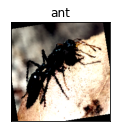

In [13]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(1):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [7]:
model = models.vgg16(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
import torch.nn as nn

# Fix pre-trained model's parameters
for param in model.features.parameters():
    param.requires_grad = False

# Change the number of the output neurons from 1000 to len(classes) 2
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer

# Move the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model.classifier[6].out_features)
print(model)

2
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [11]:
# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [10]:
# A function to encapsulate the training loop
def training(model, criterion, optimizer, training_loader, testing_loader, epochs):
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for ep in range(epochs):

        train_loss = 0.0
        train_acc = 0.0
        test_loss = 0.0
        test_acc = 0.0
        
        model.train()
        for inputs, labels in training_loader:
            inputs,labels = inputs.to(device),labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_loss += loss.item()
            train_acc += torch.sum(preds == labels.data)

        model.eval()
        for inputs, labels in testing_loader:
            inputs,labels = inputs.to(device),labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            test_loss += loss.item()
            test_acc += torch.sum(preds == labels.data)

        train_epoch_loss = train_loss/len(training_loader.dataset)
        train_epoch_acc = train_acc.float()/ len(training_loader.dataset)
        train_loss_history.append(train_epoch_loss)
        train_acc_history.append(train_epoch_acc)

        test_epoch_loss = test_loss/len(testing_loader.dataset)
        test_epoch_acc = test_acc.float()/ len(testing_loader.dataset)
        test_loss_history.append(test_epoch_loss)
        test_acc_history.append(test_epoch_acc)
        print(f'Epoch {ep+1}/{epochs}:')
        print(f'Train loss: {train_epoch_loss:.4f}, Train accuracy: {train_epoch_acc.item():.4f}.')
        print(f'Test loss: {test_epoch_loss:.4f}, Test accuracy: {test_epoch_acc.item():.4f}.')

    return train_loss_history,train_acc_history,test_loss_history,test_acc_history

In [14]:
# Training process
train_loss_history,train_acc_history,test_loss_history,test_acc_history = training(
    model, criterion, optimizer, training_loader, testing_loader, epochs=5)


Epoch 1/5:
Train loss: 0.0252, Train accuracy: 0.7705.
Test loss: 0.0104, Test accuracy: 0.9346.
Epoch 2/5:
Train loss: 0.0201, Train accuracy: 0.8443.
Test loss: 0.0098, Test accuracy: 0.9412.
Epoch 3/5:
Train loss: 0.0165, Train accuracy: 0.8934.
Test loss: 0.0096, Test accuracy: 0.9346.
Epoch 4/5:
Train loss: 0.0135, Train accuracy: 0.9057.
Test loss: 0.0092, Test accuracy: 0.9477.
Epoch 5/5:
Train loss: 0.0096, Train accuracy: 0.9221.
Test loss: 0.0115, Test accuracy: 0.9477.


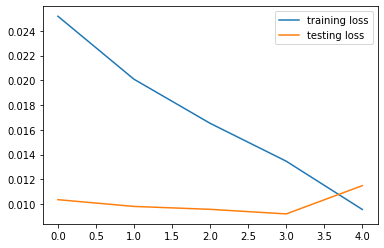

In [15]:
plt.plot(train_loss_history, label='training loss')
plt.plot(test_loss_history, label='testing loss')
plt.legend()

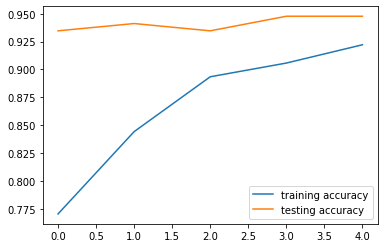

In [16]:
plt.plot(train_acc_history, label='training accuracy')
plt.plot(test_acc_history, label='testing accuracy')
plt.legend()

In [17]:
import PIL.ImageOps

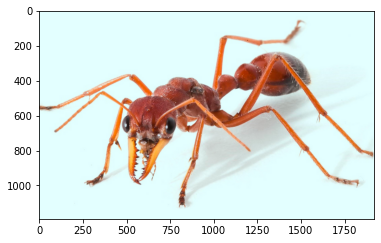

In [18]:
import requests
from PIL import Image

url = 'http://cdn.sci-news.com/images/enlarge5/image_6425e-Giant-Red-Bull-Ant.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

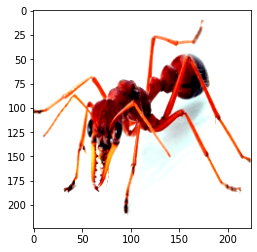

In [19]:
img = transform(img) 
plt.imshow(im_convert(img))

In [20]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

ant


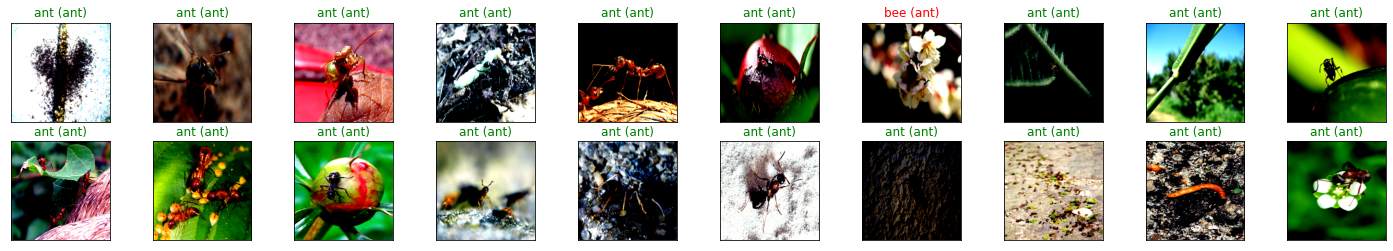

In [22]:
dataiter = iter(testing_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))